In [1]:
!pip install datasets[audio] torchaudio librosa pyannote.audio kaggle onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.7/208.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Loading dataset from kaggle

Ensure that you have [kaggle key](https://www.kaggle.com/docs/api) in your directory

In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ # path to your kaggle key
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

100% 3.67G/3.69G [00:39<00:00, 165MB/s]
100% 3.69G/3.69G [00:39<00:00, 99.6MB/s]


In [4]:
!unzip /content/deep-voice-deepfake-voice-recognition.zip

Archive:  /content/deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-taylor.wav  
  inflating: KAGGLE/AUDIO/

In [21]:
import torch
import torchaudio
from torchaudio import load
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Audio, concatenate_datasets, Dataset
from tqdm import tqdm
import os
from glob import glob
from random import random
import librosa
import torchaudio
import warnings
from pyannote.audio import Model
warnings.filterwarnings("ignore")

## Augmenting real data
Since we have less files with human audio, we generate augmented samples of those so we have more of a balanced dataset for fine-tuning

In [6]:
import librosa
import numpy as np
import os
import random
import soundfile as sf

# Function to load audio file using Librosa
def load_audio(file_path, target_sr=16000):
    audio, _ = librosa.load(file_path, sr=target_sr)
    return audio

# Function to add random noise to audio
def add_noise(audio, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(audio))
    augmented_audio = audio + noise
    return augmented_audio

# Function to perform time stretching on audio
def time_stretch(audio, rate=1.2):
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

# Function to perform pitch shifting on audio
def pitch_shift(audio, semitone_steps=2):
    augmented_audio = librosa.effects.pitch_shift(audio, sr=16000, n_steps=semitone_steps)
    return augmented_audio

# Function to save augmented audio
def save_audio(audio, output_path, sr=16000):
  """Saves augmented audio using soundfile."""
  sf.write(output_path, audio, sr, subtype='PCM_16')


# Function to augment audio and save the augmented samples
def augment_and_save(input_folder, output_folder, num_augmentations=5):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through audio files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(input_folder, filename)
            audio = load_audio(file_path)

            # Augment and save multiple times
            for i in range(num_augmentations):
                augmented_audio = audio

                # Apply random augmentation
                augmentation_type = random.choice(['noise', 'time_stretch', 'pitch_shift'])
                if augmentation_type == 'noise':
                    augmented_audio = add_noise(augmented_audio)
                elif augmentation_type == 'time_stretch':
                    augmented_audio = time_stretch(augmented_audio)
                elif augmentation_type == 'pitch_shift':
                    augmented_audio = pitch_shift(augmented_audio)

                # Save augmented audio
                output_filename = f"{os.path.splitext(filename)[0]}_aug_{i+1}.wav"
                output_path = os.path.join(output_folder, output_filename)
                save_audio(augmented_audio, output_path)

# Example usage
input_folder = "/content/KAGGLE/AUDIO/REAL"
output_folder = "/content/KAGGLE/AUDIO/REAL"
augment_and_save(input_folder, output_folder, num_augmentations=3)


## Loading audio files
- This following code reads .wav files from a directory, converts them to labeled audio features, and resamples them to a uniform format.
- Hugging Face datasets are used to manage the data, including splitting into training, validation, and test sets.
- The datasets are loaded into PyTorch Dataloaders

In [7]:
def get_file_list(directory):
    """Prints the audio length in seconds for all .wav files in a directory and its subdirectories."""
    # Create an empty list to store the file paths
    path_list = []
    # Walk through the directory and its subdirectories
    for root, _, filenames in os.walk(directory):
        # Iterate through the files
        for filename in filenames:
            # Check if the file is a .wav file
            if filename.endswith(".wav"):
                # Create the file path by joining the root and the file name
                filepath = os.path.join(root, filename)
                # Add the file path to the list
                path_list.append(filepath)
    # Return the list of .wav file paths
    return path_list

def create_dataset_from_directory(directory, label, max_files=None):
    """Creates a labelled dataset from a directory of .wav files."""
    # Get the list of .wav file paths using the get_file_list function
    path_list = get_file_list(directory)
    # If the max_files parameter is not None, limit the file paths to the specified number
    if max_files is not None:
        path_list = path_list[:max_files]
    # Create a dataset from the list of file paths with the "audio" column
    audio_dataset = Dataset.from_dict({"audio": path_list}).cast_column("audio", Audio())
    # Convert the dataset to a pandas dataframe
    df = audio_dataset.to_pandas()
    # Add a 'label' column to the dataframe with the specified label
    df['label'] = label
    # Create a new dataset from the pandas dataframe
    dataset_labelled = Dataset.from_pandas(df)
    # Convert the "audio" column to the Audio feature, resampling to a sampling rate of 16000 Hz and converting to mono
    dataset_labelled = dataset_labelled.cast_column("audio", Audio(sampling_rate=16000, mono=True))
    # Return the labelled dataset
    return dataset_labelled

In [8]:
# creating datasets from directory
real_dataset = create_dataset_from_directory("/content/KAGGLE/AUDIO/REAL", label=1)
fake_dataset = create_dataset_from_directory("/content/KAGGLE/AUDIO/FAKE", label=0)

# Combine the datasets
combined_dataset = concatenate_datasets([real_dataset, fake_dataset])

In [9]:
def collate(batch):
    # get the audio
    audio = torch.tensor([sample['audio']['array'] for sample in batch])
    # Get the labels
    labels = torch.tensor([sample['label'] for sample in batch])
    # Return the padded audio and labels
    return {'audio': audio, 'label': labels}

# Set a random seed for reproducibility
random_seed = 42  # You can choose any arbitrary integer as the seed
torch.manual_seed(random_seed)

# Perform the random split for training and validation datasets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Further split the validation set into validation and test sets
val_size = int(0.5 * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Create DataLoaders for the training, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(70, 9, 9)

### Log in to HuggingFace
This is done to download the pre-trained model from huggingface

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Download the pre-trained model
For this example, we are using the WeSpeaker model, pre-trained on voxceleb dataset, wrapped by pyannote-audio library.

In [10]:
from pyannote.audio import Model

base_model = Model.from_pretrained("pyannote/wespeaker-voxceleb-resnet34-LM")

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [11]:
import torch
# setting device to GPU if available, othervise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Preparing for fine-tuning
Freeze all the layers of the base model.
Add a classifier head for Binary Classification.

In [12]:
from torch import nn

class WeSpeakerResNet34WithClassifier(nn.Module):
    def __init__(self, model: nn.Module, num_classes=2):
        super().__init__()

        # Move the model to GPU if available
        self.base_model = model.to(device)

        # Freeze the parameters of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the custom network with the base model and specify the number of classes
model = WeSpeakerResNet34WithClassifier(num_classes=2, model=base_model)


In [20]:
next(iter(train_dataloader))['audio'].unsqueeze(0).float().to(device).shape

torch.Size([1, 1, 8005992])

# Run the model through a training loop

In [ ]:
import torch
import time
import torch.nn as nn
from tqdm import tqdm  # Assuming you have tqdm installed

def train_model(model, train_dataloader, val_dataloader, num_epochs=2, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch number: {epoch + 1}")

        # Training phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        correct = 0
        total = 0
        rows = len(train_dataloader)
        step = rows / 10

        with tqdm(total=len(train_dataloader)) as pbar:
            for i, batch in enumerate(train_dataloader):
                # Move data to GPU if available
                audio = batch["audio"].unsqueeze(0).float().to(device)
                label = batch['label'].long().to(device)

                # Forward pass, loss calculation, optimizer step (same as before)
                output = model(audio)
                loss = criterion(output, label)
                running_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress bar and accuracy metrics (same as before)
                pbar.update(1)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        # Calculate training loss and accuracy
        average_loss = running_loss / len(train_dataloader)
        accuracy = correct / total * 100 if total != 0 else 0

        # Validation phase
        model.eval()  # Set model to evaluation mode

        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for val_batch in val_dataloader:
                val_audio = val_batch["audio"].unsqueeze(0).float().to(device)
                val_label = val_batch['label'].long().to(device)

                val_output = model(val_audio)
                val_loss = criterion(val_output, val_label)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()

        # Calculate validation loss and accuracy
        val_average_loss = val_running_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total * 100 if val_total != 0 else 0

        # Print training and validation results
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}, Training Accuracy: {accuracy:.2f}%, Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


In [ ]:
train_model(model, train_dataloader, val_dataloader)

Epoch number: 1


100%|██████████| 70/70 [03:26<00:00,  2.94s/it]


Epoch [1/1], Training Loss: 0.4492, Training Accuracy: 81.43%, Validation Loss: 0.1594, Validation Accuracy: 88.89%


## Evaluation
The following code is used for evaluation the model. It calculates the accuracy, precision, recall and the F1 score on the given dataloader. It also prints the confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Compute the confusion matrix using scikit-learn's confusion_matrix function
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a figure for the plot with specified size
    plt.figure(figsize=(8, 6))

    # Plot the confusion matrix as a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Set labels for the x and y axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Set the title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


def process_audio_batch(model, dataloader):
    model.eval()  # Set model to evaluation mode

    # initializing empty lists to store prediction and ground truth
    predictions = []
    ground_truths = []

    # initializing labels
    labels = ["fake", "real"]

    # Pass each batch through the model without gradient calculation
    for batch in dataloader:
        # Move data to GPU if available
        audio = batch["audio"].unsqueeze(0).float().to(device)
        label = batch['label'].long().to(device)
        # run the model in inference mode
        with torch.no_grad():
            output = model(audio)
        # add the predictions and ground truth to the list
        predictions.extend(output.argmax(dim=1).tolist())
        ground_truths.extend(label.tolist())

    # Check if all labels are present in the ground truth
    unique_labels = set(ground_truths + predictions)
    if not set(labels).issubset(unique_labels):
        # print("Warning: Not all specified labels are present in the ground truth.")
        # print(f"Present labels in ground truth: {unique_labels}")
        labels = list(unique_labels)

    # Calculate metrics after processing all batches
    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions, average='weighted')
    recall = recall_score(ground_truths, predictions, average='weighted')
    f1 = f1_score(ground_truths, predictions, average='weighted')

    # Create confusion matrix
    plot_confusion_matrix(ground_truths, predictions, labels)

    return predictions, ground_truths, accuracy, precision, recall, f1

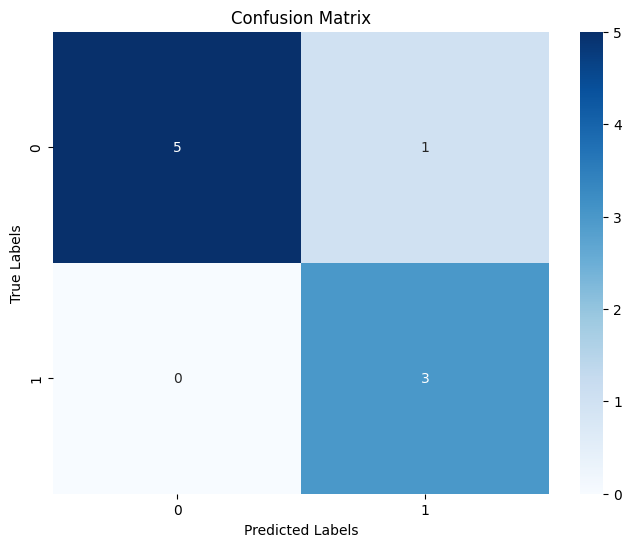

Accuracy: 0.8888888888888888
Precision: 0.9166666666666666
Recall 0.8888888888888888
F1 Score: 0.8917748917748918


In [ ]:
_, _, accuracy, precision, recall, f1 = process_audio_batch(model, test_dataloader)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall {recall}\nF1 Score: {f1}")

## Saving the model

In [ ]:
torch.save(model, '/content/model.pt')